In [6]:
import torch
import os
import numpy as np
import matplotlib.pyplot as plt
import torch.utils.data
from torchvision import transforms
from tqdm import tqdm_notebook
import math
import torch.nn as nn
import torchvision
from training.dataset.dataset_cifar import *
from training.models.models_resnet_cifar import *
from training.models.models_vgg import* 
import training.models.models_vgg as models_vgg

In [21]:
'''vgg16'''
#imbalanced_net_vgg = models.models_vgg.vgg16_10_bn()
#balanced_net_vgg = models.models_vgg.vgg16_10_bn()

'''vgg11'''
imbalanced_net_vgg = models_vgg.vgg11_10_bn()
balanced_net_vgg = models_vgg.vgg11_10_bn()


In [25]:
'''vgg11'''
imbalanced_net_vgg.load_state_dict(torch.load(model_dir)["net"])
net = imbalanced_net_vgg


#balanced_net_vgg.load_state_dict(torch.load(model_dir)["net"])
#net = balanced_net_vgg

net.eval()
net.cuda()

VGG_10(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU(inplace=True)
    (14): MaxPool2d

# Add hook after the each layer

In [38]:
hidden_outputs = {}
def named_hook(name):
    def hook(module, input, output):
        hidden_outputs[name] = output
    return hook

activations = dict(features_2=[], features_6=[], features_10=[], features_13=[],
                   features_17=[], features_20=[], features_24=[],
                   features_27=[], classifier_1=[], classifier_4=[])

'''
vgg16
activations = dict(features_12=[], features_16=[], features_19=[],
                   features_22=[], features_26=[], features_29=[],
                   features_32=[], features_36=[], features_39=[],
                   features_42=[], classifier_1=[], classifier_4=[])
'''

for name in activations.keys():
    meta_arch_name, layer_idx = name.split('_')
    layer_idx = int(layer_idx)
    if meta_arch_name == 'features':
        net.features[layer_idx].register_forward_hook(named_hook(meta_arch_name+'_'+str(layer_idx)))
    elif meta_arch_name == 'classifier':
        net.classifier[layer_idx].register_forward_hook(named_hook(meta_arch_name+'_'+str(layer_idx)))

# Load cifar10 test set 

In [28]:
cifar10 = Cifar10(directory=dir10)
#cifar100 = Cifar100(directory=dir100)

test_X = cifar10.ordered_test_X
test_Y = cifar10.ordered_test_Y

transform_test = transforms.Compose([transforms.ToTensor(),
                                                  transforms.Normalize([0.5071, 0.4866, 0.4409],
                                                                       [0.2673, 0.2564, 0.2762])
                                                  ])
num_class = 10
imgs_per_class = 1000 
batch_size = 100
iters_per_class = imgs_per_class//batch_size
assert imgs_per_class/batch_size == float(iters_per_class)

dset = CustomDataset(test_X, test_Y, transform=transform_test)
dloader = torch.utils.data.DataLoader(dset, batch_size=batch_size, shuffle=False)

# Calculate the Activation Value

In [39]:
print('start extracting class-conditional hidden activations.')
loader = iter(dloader)
for i in tqdm_notebook(range(num_class)):
    
    class_conditional_activations = dict()
    for name in activations:
        class_conditional_activations[name] = 0.
        #class_conditional_channel_activations[name] = 0.
    for k in range(iters_per_class):
        img, label = loader.next()
        img = img.cuda()
        net(img)

        for name in activations:
            meta_arch_name, layer_idx = name.split('_')
            layer_idx = int(layer_idx)
            output_name = meta_arch_name+'_'+str(layer_idx)
            
            class_conditional_activations[name] += hidden_outputs[output_name].view(batch_size, -1).sum(0).div(imgs_per_class).data.cpu()
            
    for name in activations:
        activations[name].append(class_conditional_activations[name])
        
print('merge activations. this takes time if save_outputs==True')
for name in activations:
    activations[name] = torch.stack(activations[name], dim=0)
    
    if save_outputs:
        activations_path = os.path.join(output_dir, name+'_activations.pth')
        with open(activations_path, 'wb+') as f:
            torch.save(activations[name], activations_path)
        print('{} is saved'.format(activations_path))    

start extracting class-conditional hidden activations.



merge activations. this takes time if save_outputs==True
C:/Users/Hongjun/git_repository/Class_Imbalance_inside_CNNs\class_selectivity_ckpt\features_2_activations.pth is saved
C:/Users/Hongjun/git_repository/Class_Imbalance_inside_CNNs\class_selectivity_ckpt\features_6_activations.pth is saved
C:/Users/Hongjun/git_repository/Class_Imbalance_inside_CNNs\class_selectivity_ckpt\features_10_activations.pth is saved
C:/Users/Hongjun/git_repository/Class_Imbalance_inside_CNNs\class_selectivity_ckpt\features_13_activations.pth is saved
C:/Users/Hongjun/git_repository/Class_Imbalance_inside_CNNs\class_selectivity_ckpt\features_17_activations.pth is saved
C:/Users/Hongjun/git_repository/Class_Imbalance_inside_CNNs\class_selectivity_ckpt\features_20_activations.pth is saved
C:/Users/Hongjun/git_repository/Class_Imbalance_inside_CNNs\class_selectivity_ckpt\features_24_activations.pth is saved
C:/Users/Hongjun/git_repository/Class_Imbalance_inside_CNNs\class_selectivity_ckpt\features_27_activatio

# Calculate Class selectivity and others

In [40]:
print('start calculating class selectivity index')
result = {}
for name in activations:
    layer_act = activations[name]

    num_class, num_neuron = layer_act.size()
    dead_neuron_class = torch.tensor(num_class)
    dead_neuron_confidence = torch.tensor(0.)
    class_neuron_acitivty = []
    max_class_neuron_activity = []
    
    selected_class = []
    selectivity_index = []
    for neuron_idx in tqdm_notebook(range(num_neuron)):
        mu_max = torch.tensor(0.)
        mu_mmax = torch.tensor(0.)
        neuron_act = layer_act[:, neuron_idx]
        

        # In the case of mean activations of a neuron are all zero across whole classes
        # Simply consider that neuron as dead neuron.

        
        if neuron_act.nonzero().size(0) == 0: 
            class_selected = dead_neuron_class
            class_confidence = dead_neuron_confidence
        else:
            class_selected = neuron_act.argmax()
            mu_max = neuron_act[class_selected]
            mu_mmax = (neuron_act.sum()-mu_max).div(num_class-1)
            class_confidence = (mu_max-mu_mmax).div(mu_max+mu_mmax)
            
            
        if class_confidence == 0 :
            if mu_mmax > mu_max : 
                print("something is wrong")
            
        
        selected_class.append(class_selected)   
        selectivity_index.append(class_confidence)
        class_neuron_acitivty.append(neuron_act)
        max_class_neuron_activity.append(mu_max)
        
    neuron_act = layer_act[:, neuron_idx]
    
    selected_class = torch.stack(selected_class, 0)
    selectivity_index = torch.stack(selectivity_index, 0)
    class_neuron_activity = torch.stack(class_neuron_acitivty, 0)
    max_class_neuron_activity = torch.stack(max_class_neuron_activity,0)
    
    result[name] = dict()
    result[name]['selected_class'] = selected_class
    result[name]['selectivity_index'] = selectivity_index
    result[name]['class_neuron_activity'] = class_neuron_activity
    result[name]['max_class_neuron_activity'] = max_class_neuron_activity
    
    if save_outputs:
        result_path = os.path.join(output_dir, name+'_selectivity_results.pth')
        with open(result_path, 'wb+') as f:
            torch.save(result[name], result_path)
        print('{} is saved'.format(result_path))

start calculating class selectivity index



C:/Users/Hongjun/git_repository/Class_Imbalance_inside_CNNs\class_selectivity_ckpt\features_2_selectivity_results.pth is saved



C:/Users/Hongjun/git_repository/Class_Imbalance_inside_CNNs\class_selectivity_ckpt\features_6_selectivity_results.pth is saved



C:/Users/Hongjun/git_repository/Class_Imbalance_inside_CNNs\class_selectivity_ckpt\features_10_selectivity_results.pth is saved



C:/Users/Hongjun/git_repository/Class_Imbalance_inside_CNNs\class_selectivity_ckpt\features_13_selectivity_results.pth is saved



C:/Users/Hongjun/git_repository/Class_Imbalance_inside_CNNs\class_selectivity_ckpt\features_17_selectivity_results.pth is saved



C:/Users/Hongjun/git_repository/Class_Imbalance_inside_CNNs\class_selectivity_ckpt\features_20_selectivity_results.pth is saved



C:/Users/Hongjun/git_repository/Class_Imbalance_inside_CNNs\class_selectivity_ckpt\features_24_selectivity_results.pth is saved



C:/Users/Hongjun/git_repository/Class_Imbalance_inside_CNNs\class_selectivity_ckpt\features_27_selectivity_results.pth is saved



C:/Users/Hongjun/git_repository/Class_Imbalance_inside_CNNs\class_selectivity_ckpt\classifier_1_selectivity_results.pth is saved



C:/Users/Hongjun/git_repository/Class_Imbalance_inside_CNNs\class_selectivity_ckpt\classifier_4_selectivity_results.pth is saved


# Summary of the meausre for each layer

In [41]:
mi_i = np.arange(0,5)
ma_i = np.arange(5,10)
print(ma_i)

for name in activations.keys() :
    print(name)
    a = result[name]["selected_class"].cuda()
    b = torch.histc(a, bins=100, min=0, max=100, out=None)
    ma_class = torch.sum(b[5:10]).item()
    mi_class = torch.sum(b[0:5]).item()
    i = ma_class / (ma_class+mi_class)*100
    
    print("number of mi index : %.3f | number of ma index : %.3f | Neuron Membership : %.3f"% 
          (mi_class, ma_class, i))

    c = result[name]['selected_class'].numpy()
    d = result[name]['selectivity_index'].numpy()
    
    mi = np.where(c<5)
    ma = np.where((c>4) & (c<10))
    mi_index = result[name]['selectivity_index'][mi].mean()
    ma_index = result[name]['selectivity_index'][ma].mean()

    print("minority_index: %.3f | majority_index : %.3f" % (mi_index, ma_index))

    mean_unit_activation = result[name]['class_neuron_activity'].mean(dim=0)
    mi_mean = mean_unit_activation[0:5].mean()
    ma_mean = mean_unit_activation[5:10].mean()
    print("minority_mean: %.5f | majority_mean : %.5f"% (mi_mean, ma_mean))

    
    dead_neuron = np.where(d == 0)
    num_dead_neuron = len(result[name]['selectivity_index'][dead_neuron].numpy())
    #print(len(num_dead_neuron))
    num_neuron = len(d)
    
    ratio = num_dead_neuron / num_neuron * 100
    print("#alive neuron : %.2f | #dead neuron : %.2f | dead neruon ratio : %.3f" % (num_neuron-num_dead_neuron,num_dead_neuron, ratio))

[5 6 7 8 9]
features_2
number of mi index : 33074.000 | number of ma index : 29355.000 | Neuron Membership : 47.021
minority_index: 0.289 | majority_index : 0.205
minority_mean: 0.10076 | majority_mean : 0.10207
#alive neuron : 62429.00 | #dead neuron : 3107.00 | dead neruon ratio : 4.741
features_6
number of mi index : 16746.000 | number of ma index : 14721.000 | Neuron Membership : 46.782
minority_index: 0.253 | majority_index : 0.250
minority_mean: 0.06691 | majority_mean : 0.06390
#alive neuron : 31467.00 | #dead neuron : 1301.00 | dead neruon ratio : 3.970
features_10
number of mi index : 7053.000 | number of ma index : 9075.000 | Neuron Membership : 56.269
minority_index: 0.302 | majority_index : 0.323
minority_mean: 0.05551 | majority_mean : 0.05385
#alive neuron : 16128.00 | #dead neuron : 256.00 | dead neruon ratio : 1.562
features_13
number of mi index : 5449.000 | number of ma index : 10171.000 | Neuron Membership : 65.115
minority_index: 0.396 | majority_index : 0.431
minor

# Print Neuron Membership

In [37]:
print("Major Neuron Membership")  
for name in activations.keys() :
    a = result[name]["selected_class"].cuda()
    b = torch.histc(a, bins=100, min=0, max=100, out=None)
    ma_class = torch.sum(b[5:10]).item()
    mi_class = torch.sum(b[0:5]).item()
    i = ma_class / (ma_class+mi_class)*100
    print(i)

print()
print("#minor node")    
for name in activations.keys() :
    a = result[name]["selected_class"].cuda()
    b = torch.histc(a, bins=100, min=0, max=100, out=None)
    ma_class = torch.sum(b[5:10]).item()
    mi_class = torch.sum(b[0:5]).item()
    i = ma_class / (ma_class+mi_class)*100
    
    print(mi_class)
    
print()
print("#major node")    
for name in activations.keys() :
    a = result[name]["selected_class"].cuda()
    b = torch.histc(a, bins=100, min=0, max=100, out=None)
    ma_class = torch.sum(b[5:10]).item()
    mi_class = torch.sum(b[0:5]).item()
    i = ma_class / (ma_class+mi_class)*100
    
    print(ma_class)
    
print()
print("#dead node")
for name in activations.keys() :
    d = result[name]['selected_class'].numpy()
    dead_neuron = np.where(d == 10)
    num_dead_neuron = len(result[name]['selected_class'][dead_neuron].numpy())
    
    print(num_dead_neuron)
    



major activation mean
0.07247017323970795
0.04523634538054466
0.03711488097906113
0.01754903607070446
0.0190312247723341
0.018226010724902153
0.019350910559296608
0.062135495245456696
0.18033568561077118
0.34428486227989197

minor activation mean
0.0713135153055191
0.04716440290212631
0.037675097584724426
0.016681397333741188
0.018709514290094376
0.017288578674197197
0.0183662511408329
0.062360942363739014
0.17254328727722168
0.32335609197616577

#minor node
30826
17252
7645
6683
3520
3352
943
1032
194
191

#major node
32653
15499
8739
9509
4592
4776
1105
988
225
321

#dead node
2057
17
0
192
80
64
0
28
93
0
max ma class acitvation mean


NameError: name 'man' is not defined

# Print Major activation - Minor activation

In [42]:
print()    
print("major activation mean")
for name in activations.keys() :   
    mean_unit_activation = result[name]['class_neuron_activity'].mean(dim=0)
    ma_mean = mean_unit_activation[5:10].mean()
    print(ma_mean.item())    

print()
print("minor activation mean")
for name in activations.keys() :
    mean_unit_activation = result[name]['class_neuron_activity'].mean(dim=0)
    mi_mean = mean_unit_activation[0:5].mean()
    print(mi_mean.item())
    
print()
print("minor activation mean")
for name in activations.keys() :
    mean_unit_activation = result[name]['class_neuron_activity'].mean(dim=0)
    mi_mean = mean_unit_activation[0:5].mean()
    ma_mean = mean_unit_activation[5:10].mean()
    print((ma_mean-mi_mean).item())


major activation mean
0.10207079350948334
0.06389699876308441
0.05384739115834236
0.026116643100976944
0.033550821244716644
0.03377349674701691
0.031319908797740936
0.05770065635442734
0.14064298570156097
0.28428107500076294

minor activation mean
0.10075847059488297
0.0669100359082222
0.05551455169916153
0.024453671649098396
0.03135256841778755
0.03006330132484436
0.03334086015820503
0.06773336976766586
0.13031379878520966
0.201124906539917

minor activation mean
0.0013123229146003723
-0.003013037145137787
-0.001667160540819168
0.0016629714518785477
0.0021982528269290924
0.0037101954221725464
-0.002020951360464096
-0.010032713413238525
0.010329186916351318
0.08315616846084595


# Print Class selecitivty of each layer

In [43]:
mi_i = np.arange(0,5)
ma_i = np.arange(5,10)
print(mi_i)
print(ma_i)
c = result[name]['selected_class'].numpy()
'''Mean of class selectivity'''

print("selectivity index mean")
for name in activations.keys() :
    a = result[name]['selectivity_index'].mean().item()
    print(result[name]['selectivity_index'].mean().item())
    

print()
print("selectivity index median")

for name in activations.keys() :
    print(result[name]['selectivity_index'].median().item())
    
print()
print("live neuron index mean")

for name in activations.keys() :
    temp = result[name]['selectivity_index'].numpy()
    live_neuron = np.where(temp > 0)
    print(result[name]['selectivity_index'][live_neuron].mean().item())

[0 1 2 3 4]
[5 6 7 8 9]
selectivity index mean
0.23753651976585388
0.24142585694789886
0.30875566601753235
0.3990122973918915
0.48247385025024414
0.546708881855011
0.6438048481941223
0.676948606967926
0.5165284276008606
0.6147475838661194

selectivity index median
0.22302120923995972
0.22833625972270966
0.2930086851119995
0.3978860378265381
0.47665151953697205
0.5523521900177002
0.6539636254310608
0.6853460669517517
0.6280291080474854
0.6048402786254883

live neuron index mean
0.24935835599899292
0.2514076232910156
0.3136565387248993
0.41852867603302
0.4867519438266754
0.5539441704750061
0.6482362151145935
0.6907774806022644
0.7052333354949951
0.6183708310127258


# Plot the Class Selecitivty Index of each layer

C:\Users\Hongjun\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
  if sys.path[0] == '':


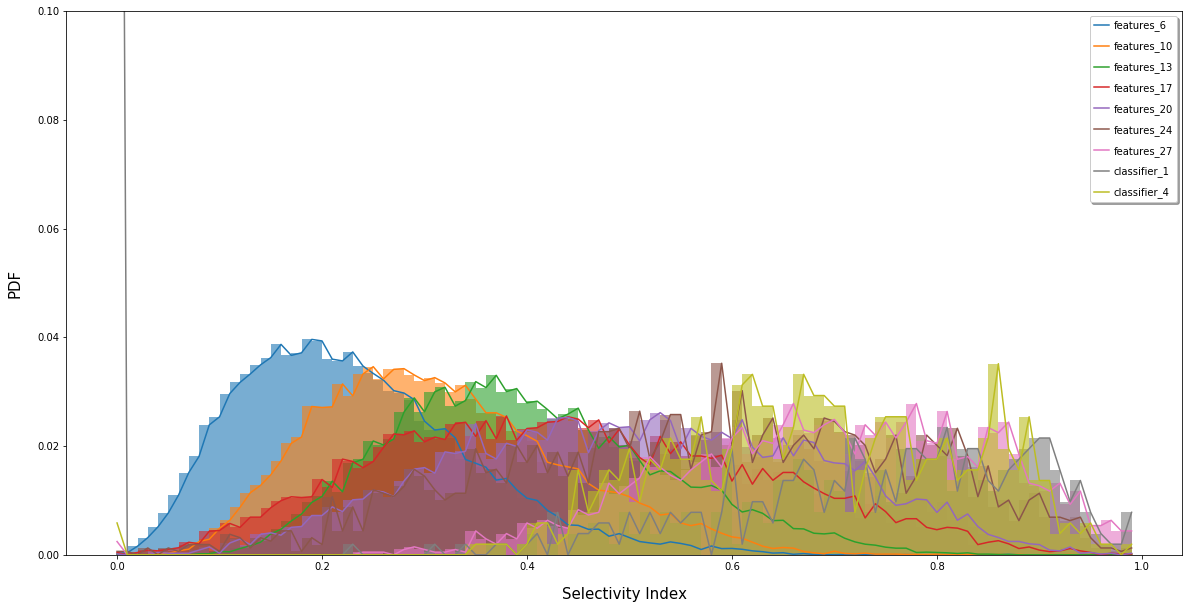

In [57]:
import matplotlib.pyplot as plt
%matplotlib inline

num_plots = len(result)
colormap = plt.cm.jet
plt.figure(figsize=(20,10))
#plt.gca().set_color_cycle([colormap(i) for i in np.linspace(0, 0.9, num_plots)]);

labels = []
for name in result:
    selectivity_index = result[name]['selectivity_index']
    selectivity_index_hist = np.histogram(selectivity_index*100, bins=100, normed=True)
    x = np.arange(len(selectivity_index_hist[0]))/len(selectivity_index_hist[0])
    y = selectivity_index_hist[0]
    plt.fill_between(x, y, step="pre", alpha=0.6)
    plt.plot(x, y)
    labels.append(name)

plt.ylim(0, 0.1)
plt.legend(labels, ncol=1, loc='upper right', 
           columnspacing=2.0, labelspacing=1,
           handletextpad=0.5, handlelength=1.5,
           fancybox=True, shadow=True)
plt.ylabel('PDF', fontsize=15, labelpad=15)
plt.xlabel('Selectivity Index', fontsize=15, labelpad=15)

#figname = os.path.join(output_dir, 'balanced_cifar10_vgg_histogram.png')
figname = os.path.join(output_dir, 'histogram_cifar10_imbalanced_vgg_100_0.5.png')
plt.savefig(figname)
plt.show()